In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile
from tqdm.auto import tqdm
from scipy.ndimage import rotate
from joblib import Parallel, delayed
import pandas as pd
from reco_helper import reconstruct_one_slice

In [2]:
%matplotlib inline

In [3]:
materials_attenuation = pd.read_csv('materials.txt', header=None, names=['index']+[i for i in range(1, 7)]+[0]+[7, 8], index_col=0)
source_spectrum = pd.read_csv('source_spectrum.txt', header=None, index_col=0, nrows=150, sep='\s+')

In [4]:
def assign_attenuations(volume, attenuations):
    """*attenuations* is in form {label: linear attenuation coefficient}."""
    result = np.zeros_like(volume, dtype=float)

    for i, value in attenuations.items():
        result[np.where(volume == i)] = value

    return result


def make_xray_image(projection, flat_intensity):
    """*projection* is the the integrated linear attenuations image."""
    return np.random.poisson(flat_intensity * np.exp(-projection))

def get_projection(angle, padded_attenuations):
    rot = rotate(
        padded_attenuations,
        -angle,
        reshape=False,
        order=1,
        axes=(1, 2)
    )
    proj = np.sum(rot, axis=1)
    return proj

def flat_correct(xray, flat_image, flat):
    fc = np.zeros_like(flat_image)
    valid = np.where(xray != 0)
    fc[valid] = np.log(flat_image[valid] / xray[valid])
    return fc.astype(np.float32)

def full_projection(angle, padded_attenuations, flat, flat_image):
    proj = get_projection(angle, padded_attenuations)
    cam = make_xray_image(proj, flat)
    return flat_correct(cam, flat_image, flat)

def make_tomographic_data_set(
    padded_attenuations,
    flat,
    num_projections,
    out_fmt=None
):
    flat_image = np.mean(
        np.random.poisson(np.ones((num_flats,) + padded_attenuations.shape[:2]) * flat),
        axis=0)
    angles = [i * 180 / num_projections for i in range(num_projections)]
    #'projections/projection-{:>04}.tif'
#     projs = Parallel(n_jobs=64)(delayed(get_projection)(i, padded_attenuations, num_projections) for i in range(num_projections))
#     cameras = [make_xray_image(proj, flat) for proj in tqdm(projs)]
#     results = Parallel(n_jobs=64)(delayed(flat_correct)(cam, flat_image, flat) for cam in cameras)
    results = Parallel(n_jobs=64)(delayed(full_projection)(angle, padded_attenuations, flat, flat_image) for angle in angles)
    if out_fmt is not None:
        Parallel(n_jobs=64)(delayed(tifffile.imwrite)(out_fmt.format(i), proj) for i, proj in enumerate(results))
    else:
        return results

In [5]:
volume = np.load('/mnt/HD-LSDF/sd18a004/for_yaroslav/simulation/simulation_phantom_512_v2.npy').astype(np.int8)

padder = int(np.ceil((np.sqrt(2) * volume.shape[1] - volume.shape[1])/2))
padded = np.pad(volume, ((0, 0), (padder, padder), (padder, padder)), mode='constant')

# num_projections = int(np.ceil(np.pi / 2 * att.shape[2]))
num_projections = 120
base_att = 1e-3
flat = 1000  # Flat field intensity
num_flats = 10


In [6]:
print(f'tofu reco --projections projections  --x-region=-{volume.shape[1]/2},{volume.shape[1]/2},1.0 --y-region=-{volume.shape[2]/2},{volume.shape[2]/2},1.0 --overall-angle 180 --region=-{volume.shape[1]/2},{volume.shape[1]/2},1.0 --output slices.tif --center-position-x {padded.shape[1]//2} --center-position-z {volume.shape[0]//2}.5')

tofu reco --projections projections  --x-region=-256.0,256.0,1.0 --y-region=-256.0,256.0,1.0 --overall-angle 180 --region=-256.0,256.0,1.0 --output slices.tif --center-position-x 363 --center-position-z 256.5


In [7]:
padded = padded[127:129]

In [8]:
import os

In [ ]:
fps = []
for channel in tqdm(range(15,150)):
    att = assign_attenuations(padded, materials_attenuation.loc[channel])/10_000
    flat = source_spectrum.loc[channel][1]/80
    projs = make_tomographic_data_set(att, 
                                      flat, 
                                      num_projections, 
#                                       out_fmt='/mnt/HD-LSDF/sd18a004/for_yaroslav/simulation_512/projections/projection-{:>04}.tif'
                                     )
    fps.append(projs)

  0%|          | 0/135 [00:00<?, ?it/s]

In [67]:
%%time
fps = np.stack(fps)

CPU times: user 10.2 s, sys: 47.8 s, total: 58 s
Wall time: 58 s


In [63]:
reco_fps = reconstruct_one_slice(np.pad(fps[..., 0, :], ((0, 0), (0, 0), (0, 28))))

reconstructing channels:   0%|          | 0/135 [00:00<?, ?it/s]

In [68]:
fps.shape

(135, 120, 512, 726)

In [69]:
reco_fps = reconstruct_one_slice(np.pad(fps[..., 127, :], ((0, 0), (0, 0), (0, 28))))

reconstructing channels:   0%|          | 0/135 [00:00<?, ?it/s]

In [147]:
np.save('/mnt/HD-LSDF/sd18a004/for_yaroslav/simulation_512/bright_projections.npy', fps[..., 0, :])

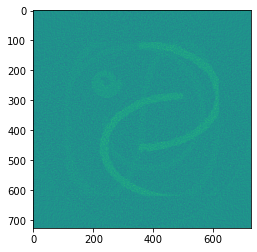

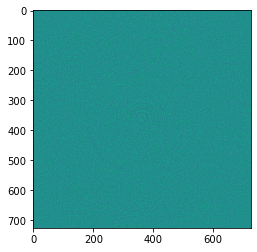

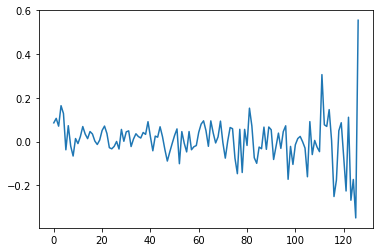

In [70]:
plt.imshow(reco_fps[41])
plt.show()

plt.imshow(reco_fps[-10])
plt.show()

plt.plot(reco_fps[:, 107:-107, 107:-107][8:, 290, 150])
plt.show()

In [71]:
for i in tqdm(range(num_projections)):
    tifffile.imwrite(f'/mnt/HD-LSDF/sd18a004/for_yaroslav/simulation_512/projections_spectrum/{i:03}.tif', fps[:, i])

  0%|          | 0/120 [00:00<?, ?it/s]

In [42]:
a = tifffile.imread('/mnt/HD-LSDF/sd18a004/for_yaroslav/simulation_512/projections_spectrum/000.tif')

In [43]:
slice_number = 127

In [44]:
sino_before = []
for i in tqdm(range(120)):
    img = tifffile.memmap(f'/mnt/HD-LSDF/sd18a004/for_yaroslav/simulation_512/projections_spectrum/{i:03}.tif')
    sino_before.append(img[:, slice_number])
sino_before = np.stack(sino_before, axis=1)

  0%|          | 0/120 [00:00<?, ?it/s]

In [45]:
reco_before = reconstruct_one_slice(np.pad(sino_before, ((0, 0), (0, 0), (0, 28))))

reconstructing channels:   0%|          | 0/135 [00:00<?, ?it/s]

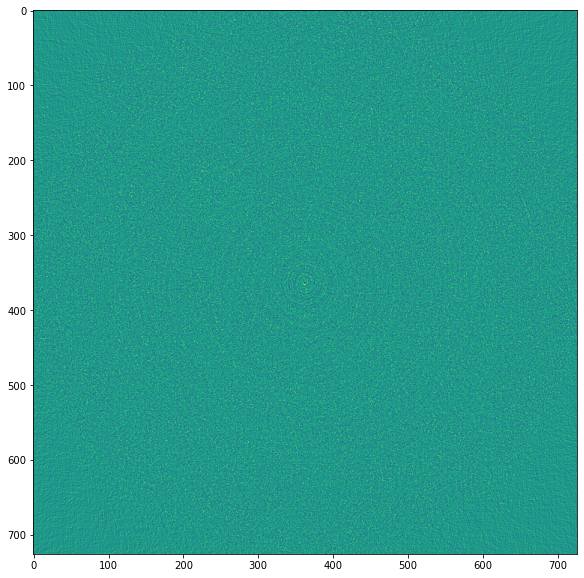

In [50]:
plt.figure(figsize=(16, 10))
plt.imshow(reco_before[-10])

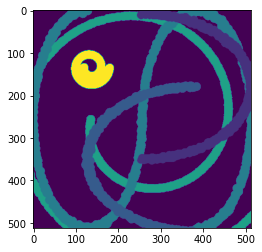

In [46]:
plt.imshow(volume[127])

In [31]:
sino_after = []
for i in tqdm(range(120)):
    img = tifffile.memmap(f'/mnt/HD-LSDF/sd18a004/for_yaroslav/simulation_512/projections_spectrum_processed/{i:03}.tif')
    sino_after.append(img[:, slice_number])
sino_after = np.stack(sino_after, axis=1)

  0%|          | 0/120 [00:00<?, ?it/s]

In [32]:
reco_after = reconstruct_one_slice(np.pad(sino_after, ((0, 0), (0, 0), (0, 28))))
reco_after = np.concatenate([reco_after[[0]], reco_after, reco_after[[-1]]])

reconstructing channels:   0%|          | 0/133 [00:00<?, ?it/s]

In [19]:
volume[127][310:320, 400:410]

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int8)

In [10]:
named_materiials_attenuation = materials_attenuation.rename(columns={1: 'Europium', 
                                                                     2: 'Gadolinium', 
                                                                     3: 'Ytterbium', 
                                                                     4: 'Lutetium', 
                                                                     5: 'Tantalum', 
                                                                     6: 'Iodine', 
                                                                     0: 'Air', 
                                                                     7: 'Uranium', 
                                                                     8: 'Radium'})

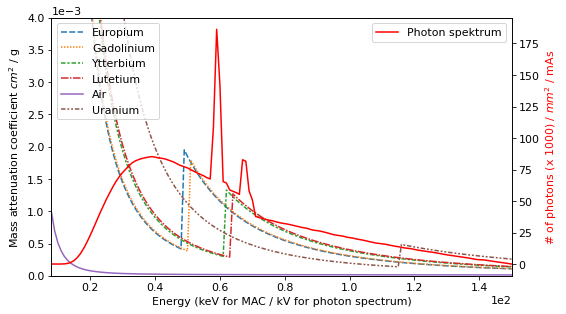

In [19]:
plt.rcParams.update({'font.size': 11, 'font.family': 'sans-serif'})
plt.figure(figsize=(8, 4.5))
# plt.plot(reco_before[:, 107:-107, 107:-107][3:, 315, 405])
# plt.plot(reco_after[:, 107:-107, 107:-107][3:, 315, 405])
# plt.plot(materials_attenuation[1].loc[18:150].values/10_000*20)
sns.lineplot(data=named_materiials_attenuation.drop(labels=['Tantalum', 'Iodine', 'Radium'], axis=1)/10_000, 
             ax=plt.gca(), 
             style_order=['Air', 'Europium', 'Gadolinium', 'Ytterbium', 'Lutetium', 'Uranium'])
plt.ylim(0, 40/10_000)
plt.xlim(8, 150)
plt.ylabel("Mass attenuation coefficient $cm^2$ / g")
plt.xlabel("Energy (keV for MAC / kV for photon spectrum)")
plt.legend(loc='upper left')
plt.gca().ticklabel_format(style='sci', scilimits=(0, 0))
ax2 = plt.gca().twinx()
ax2.set_ylabel("# of photons (x 1000) / $mm^2$ / mAs", color="r")
ax2.plot(source_spectrum/1000, 'r-', label='Photon spektrum')
plt.legend()
plt.tight_layout()
plt.savefig('figures/spectra.pdf')

index
18.0     56.106061
19.0     48.608090
20.0     42.420000
21.0     37.261805
22.0     32.923130
           ...    
146.0     1.150391
147.0     1.131071
148.0     1.112243
149.0     1.093891
150.0     1.076000
Name: 1, Length: 133, dtype: float64

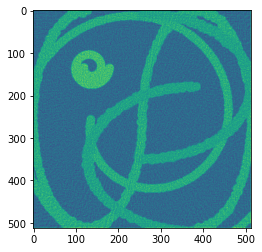

In [32]:
a.shape

(135, 512, 726)

In [46]:
import seaborn as sns

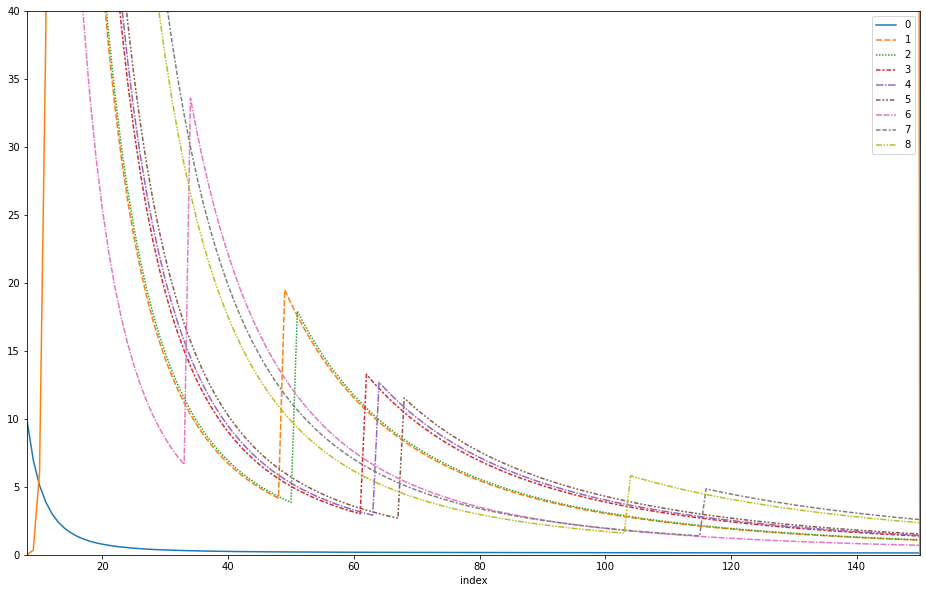

In [13]:
plt.figure(figsize=(16, 10))
sns.lineplot(data = materials_attenuation)
plt.ylim(0, 40)
plt.xlim(8, 150)
plt.plot(source_spectrum)

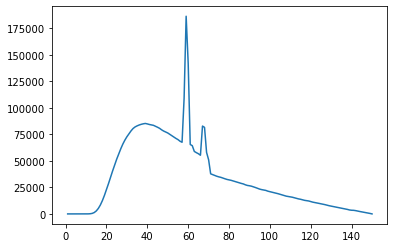

In [47]:
plt.plot(source_spectrum)

TypeError: Invalid shape (140, 0, 10, 726) for image data

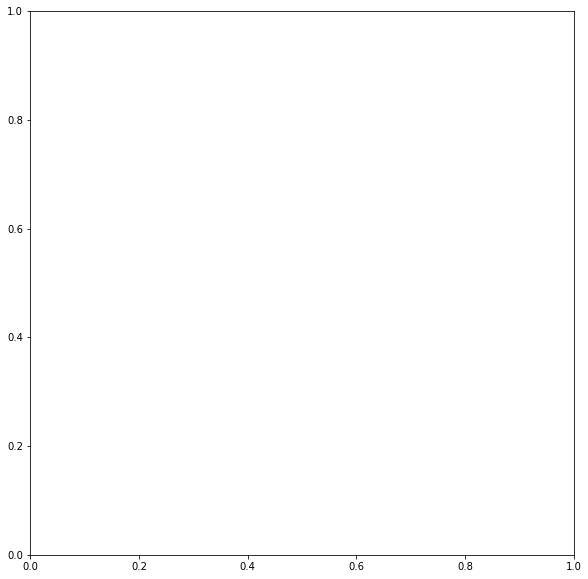

In [55]:
plt.figure(figsize=(16, 10))
plt.imshow(np.stack(fps)[:, 107:-107])

In [16]:
from reco_helper import reconstruct_one_slice

In [14]:
fps_sino = np.stack(fps)[:,:,0]

In [17]:
reco_fps = reconstruct_one_slice(np.pad(fps_sino[..., 107:-107], ((0, 0), (0, 0), (0, 28))))

reconstructing channels:   0%|          | 0/135 [00:00<?, ?it/s]

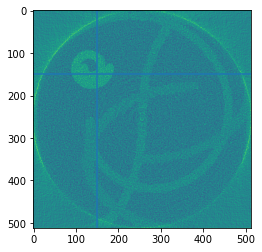

In [21]:
plt.imshow(reco_fps[30])
plt.axvline(150)
plt.axhline(150)

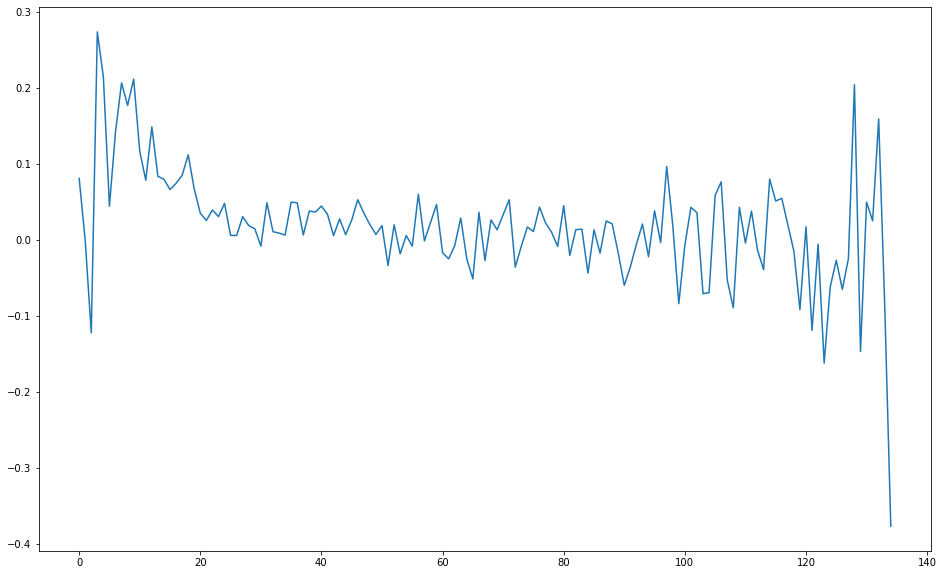

In [20]:
plt.figure(figsize=(16, 10))
plt.plot(reco_fps[:, 150, 150])

In [303]:
fps_sino.shape

(140, 120, 726)

In [122]:
a = tifffile.imread('/mnt/HD-LSDF/sd18a004/for_yaroslav/simulation_512/projections_spectrum_processed/000.tif')

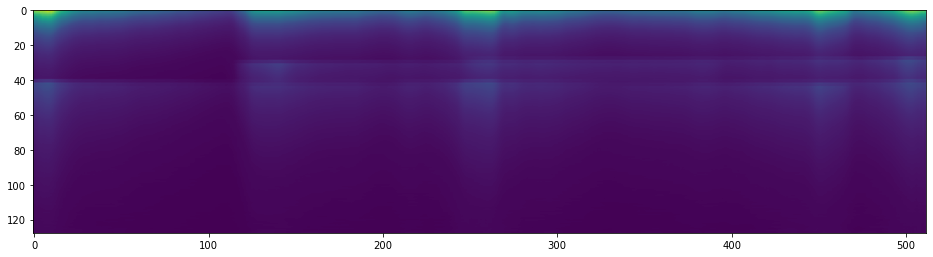

In [129]:
plt.figure(figsize=(16, 10))
plt.imshow(a[10:, 130])

In [130]:
slice_number = 127

In [131]:
sino_after = []
for i in tqdm(range(120)):
    img = tifffile.memmap(f'/mnt/HD-LSDF/sd18a004/for_yaroslav/simulation_512/projections_spectrum_processed/{i:03}.tif')
    sino_after.append(img[:, slice_number])
sino_after = np.stack(sino_after, axis=1)

  0%|          | 0/120 [00:00<?, ?it/s]

In [137]:
reco_after = reconstruct_one_slice(np.pad(sino_after, ((0, 0), (0, 0), (0, 28))))

reconstructing channels:   0%|          | 0/138 [00:00<?, ?it/s]

In [155]:
reco_after = np.concatenate([reco_after[[0]], reco_after, reco_after[[-1]]])

In [144]:
sino_before = []
for i in tqdm(range(120)):
    img = tifffile.memmap(f'/mnt/HD-LSDF/sd18a004/for_yaroslav/simulation_512/projections_spectrum/{i:03}.tif')
    sino_before.append(img[:, slice_number])
sino_before = np.stack(sino_before, axis=1)

  0%|          | 0/120 [00:00<?, ?it/s]

In [145]:
reco_before = reconstruct_one_slice(np.pad(sino_before, ((0, 0), (0, 0), (0, 28))))

reconstructing channels:   0%|          | 0/140 [00:00<?, ?it/s]

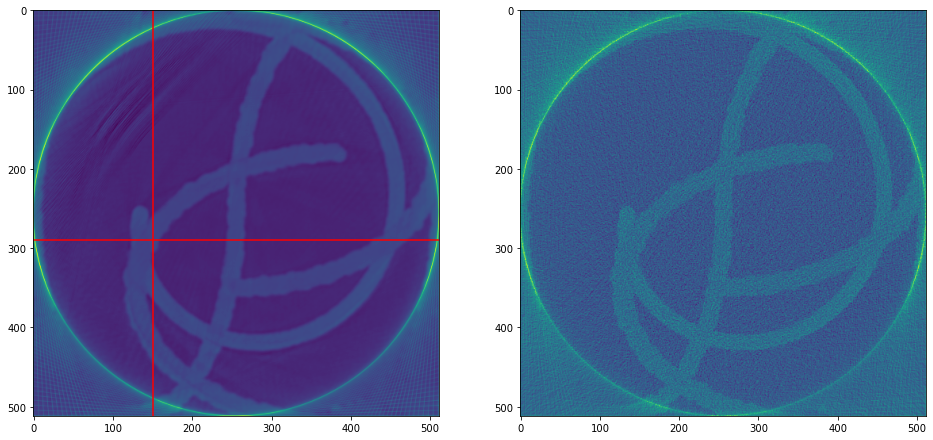

In [156]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 10))
d_x = 150
d_y = 290
ax1.imshow(reco_after.sum(0))
ax1.axvline(d_x, c='r')
ax1.axhline(d_y, c='r')

ax2.imshow(reco_before.sum(0))


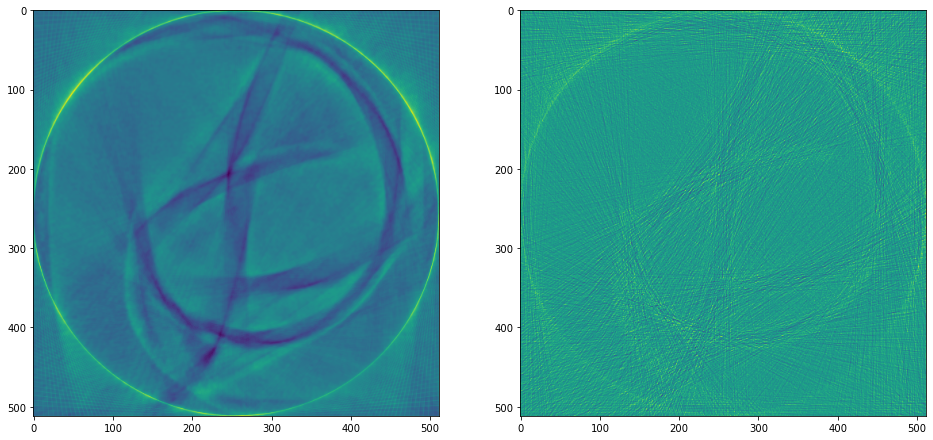

In [160]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 10))
ax1.imshow(reco_after[2])

ax2.imshow(reco_before[2])

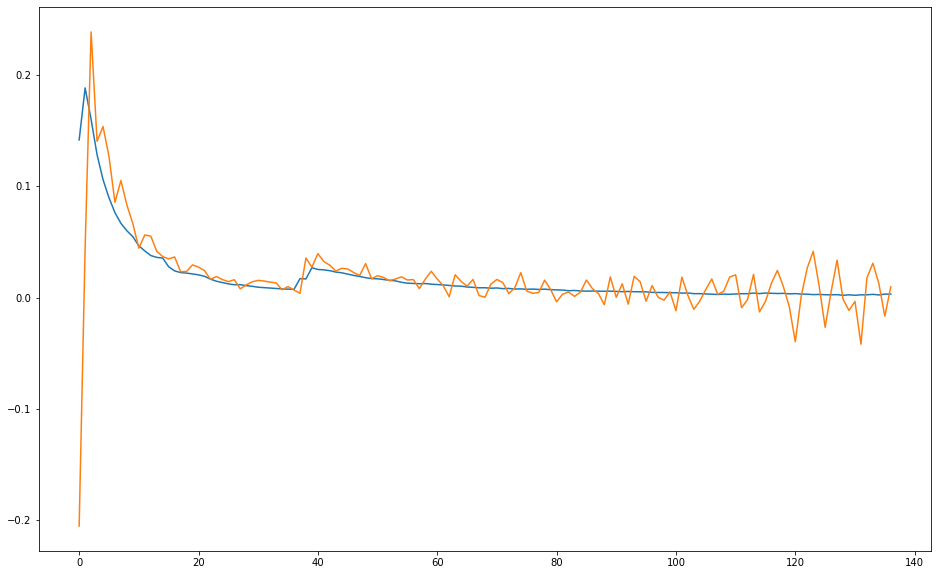

In [158]:
plt.figure(figsize=(16, 10))
plt.plot(reco_after[3:, d_y, d_x])
plt.plot(reco_before[3:, d_y, d_x])

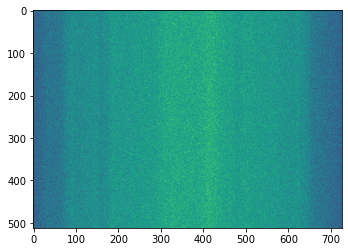

In [133]:
a = tifffile.imread('/mnt/HD-LSDF/sd18a004/for_yaroslav/simulation_512/projections/projection-0100.tif')
plt.imshow(a)

In [190]:
ls /mnt/data/decathlon/Task03_Liver/train/volumes

liver_0.tif    liver_120.tif  liver_3.tif   liver_5.tif   liver_75.tif
liver_1.tif    liver_121.tif  liver_30.tif  liver_50.tif  liver_76.tif
liver_10.tif   liver_122.tif  liver_31.tif  liver_53.tif  liver_77.tif
liver_100.tif  liver_123.tif  liver_32.tif  liver_54.tif  liver_78.tif
liver_101.tif  liver_124.tif  liver_33.tif  liver_55.tif  liver_79.tif
liver_102.tif  liver_125.tif  liver_34.tif  liver_58.tif  liver_8.tif
liver_103.tif  liver_126.tif  liver_35.tif  liver_59.tif  liver_81.tif
liver_105.tif  liver_127.tif  liver_37.tif  liver_6.tif   liver_83.tif
liver_106.tif  liver_128.tif  liver_38.tif  liver_60.tif  liver_84.tif
liver_107.tif  liver_129.tif  liver_39.tif  liver_61.tif  liver_87.tif
liver_108.tif  liver_13.tif   liver_4.tif   liver_62.tif  liver_88.tif
liver_109.tif  liver_14.tif   liver_40.tif  liver_63.tif  liver_89.tif
liver_110.tif  liver_15.tif   liver_41.tif  liver_65.tif  liver_9.tif
liver_111.tif  liver_16.tif   liver_42.tif  liver_66.tif  liver_90.tif
liver_11

In [166]:
v = tifffile.imread('/mnt/data/decathlon/Task02_Heart/train/volumes/la_003.tif')
l = tifffile.imread('/mnt/data/decathlon/Task02_Heart/train/labels/la_003.tif')

In [191]:
v = tifffile.imread('/mnt/data/decathlon/Task03_Liver/train/volumes/liver_0.tif')
l = tifffile.imread('/mnt/data/decathlon/Task03_Liver/train/labels/liver_0.tif')

In [192]:
l.shape

(75, 512, 512)

In [282]:
from skimage.segmentation import mark_boundaries
from skimage.morphology import closing, opening, disk, dilation
from skimage.transform import rescale

In [222]:
from src.callbacks import iou

In [269]:
corr_s = l[i]

In [291]:
corr_s = closing(l[i], disk(8))
corr_s = dilation(corr_s, disk(1))
iou(corr_s, l[i], 2)

array([99.61697752, 95.0706453 ])

In [293]:
corr_s = closing(l[i], disk(25))
corr_s = dilation(corr_s, disk(2))
iou(corr_s, l[i], 2)

array([99.18356813, 90.04793768])

In [295]:
corr_s = closing(l[i], disk(45))
corr_s = dilation(corr_s, disk(5))
iou(corr_s, l[i], 2)

array([98.20450533, 80.44700214])

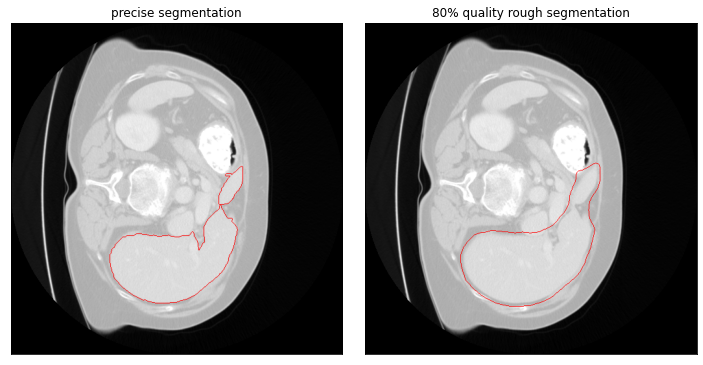

In [296]:
i = 55
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
v_s = mark_boundaries(v[i], l[i], color=(1, 0, 0), )
ax1.imshow(v_s)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('precise segmentation')

v_s = mark_boundaries(v[i], corr_s, color=(1, 0, 0))
ax2.imshow(v_s)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('80% quality rough segmentation')

plt.tight_layout()
plt.show()

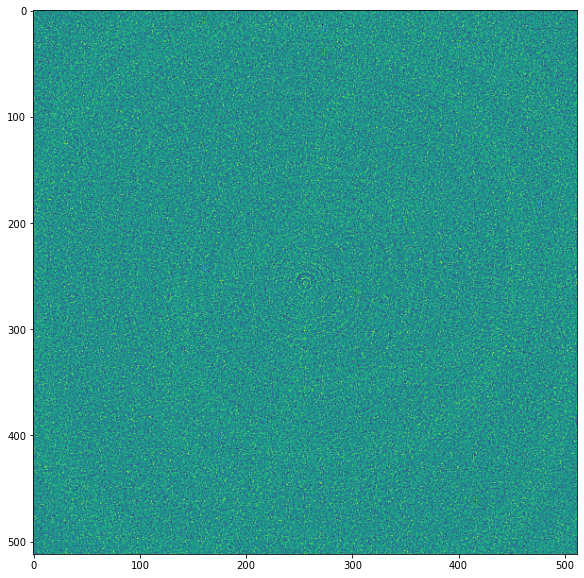

In [36]:
rec_a = tifffile.imread('/mnt/HD-LSDF/sd18a004/for_yaroslav/simulation_512/slices.tif')
plt.figure(figsize=(10, 10))
plt.imshow(rec_a[10])

In [119]:
rec_a = tifffile.imread('/mnt/HD-LSDF/sd18a004/for_yaroslav/simulation_512/slices.tif')

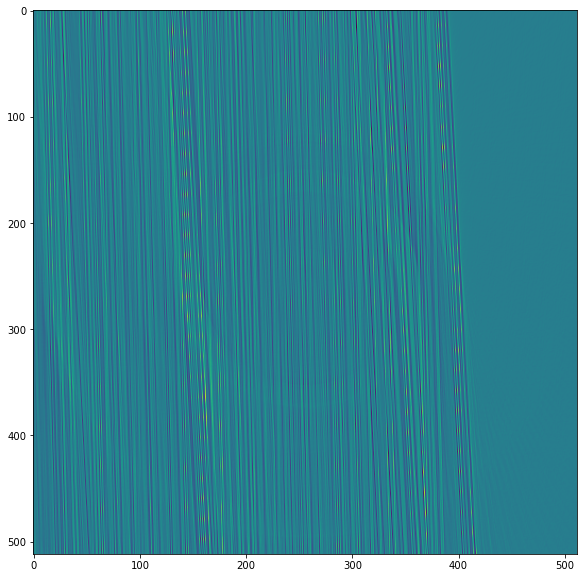

In [121]:
plt.figure(figsize=(10, 10))
plt.imshow(rec_a[10])